<a href="https://colab.research.google.com/github/annapahl24/exercise9/blob/main/Copy_of_CompModNervSys_exercise9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOL 74.03 (SP23): Computational Modeling of the Nervous System
# Exercise 9: Simulating synaptic inputs to ball-and-stick neuron models

### Exercise goals

1) Implement conductance based models of fast excitatory (AMPA) and inhibitory (GABAA) synapses

2) Understand how dendrites spatially and temporally filter synaptic inputs

3) Describe the divisive and subtractive properties of shunting inhibition

Neurons receive thousands of synapses distributed along their dendritic trees, each of which genereate either excitatory or inhibitory postsynaptic currents that act to increase or decrease, respectively, the postsynaptic potential. At any given moment, neurons are bombarded by tens of thousands of synaptic currents pulling the membrane voltage up and down throughout their extended arbors, culminating in the generation of action potentials when the action potential threshold voltage (remember, not a fixed value!) is reached at the soma and axon initial segment.

It may seem as though all these complicated interactions are just a prelude to the single important "decision" made by the neuron, whether or not to fire an AP. Indeed, early computational work and modern artificial neural networks treat neurons as simple integrators (i.e., non-leaky integrate and fire), simply summing their inputs and generating an output once a threshold is crossed, but how closely does this picture resemble real neurons?

It turns out the combination of dendritic cable properties and synaptic conductance changes leads to a variety of intradendritic computations, allowing for amplification, vetoing, modulation, mixing, and more, of the information a neuron receives throughout its elaborate dendritic architecture. In this exercise, we'll explore just a couple of questions along this vein: How does the location and timing of a synaptic input alter its effects on the postsynaptic neuron's output? How do excitatory and inhibitory inputs interact to generate the net output?

Work through the code below, running each cell, adding code where required, and making sure you understand the output. When you see questions with <font color='red'><b><i>Q:</i></b></font> preceding them, write your responses in text cells.


We'll first install neuron as usual.

In [1]:
%pip install neuron # only need to run this cell once to install
                    # neuron in the local jupyter environment

Run the code block below just once to get all the files from the repository into our colab session and compile the MOD mechanism files we'll be using

In [2]:
import os
repo_name = 'CompModNervSys-BallAndStickSynapses'

if 'google.colab' in str(get_ipython()):
    if not os.path.exists(repo_name):
        !git clone https://github.com/CompModNervSystem/{repo_name}.git # downloads repository into our Google colab session's file system

    os.chdir('/content/' + repo_name)

# Compile mechanisms
!nrnivmodl mechanisms

/content/CompModNervSys-BallAndStickSynapses
Mod files: "mechanisms/mechanisms/ProbAMPANMDA.mod" "mechanisms/mechanisms/ProbGABAA.mod" "mechanisms/mechanisms/spikeout.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


Now we can import the packages we'll be using

In [3]:
from neuron import h # all NEURON hoc functions are accessed through h
from neuron import gui # if you're running this notebook in a local environment (instead of on google colab), launches the GUI
h.load_file('stdrun.hoc') # loads neuron standard hoc library
import numpy as np
import matplotlib.pyplot as plt
import plotly

if 'google.colab' in str(get_ipython()):
    from google.colab import output
    output.enable_custom_widget_manager()
else:
  plotly.offline.init_notebook_mode()


# Passive spatial and temporal filtering of synaptic potentials

So far, we've modeled single point neurons with leaky-integrate and fire membranes, space clamped axons with hodgkin-huxley conductances, and single dendrite/axon branches. Following the pattern, we'll add some more complexity by modeling a "ball-and-stick" version of a neuron consisting of a cell body (the ball) and a single dendritic branch (the stick). This will allow us to simulate synaptic inputs at different locations within the dendrite. Dendritic branches also narrow in diameter along their length in the distal direction, so we'll capture that in our model by including a linear decrease in the dendrite's diameter from proximal to distal end.

This is all wrapped in the pre-written cell class `BallAndStick` that you'll use in this exercise, imported from `ballandstick.py`. You can take a look at this file to see the structure of the class and default parameters, and necessary functions will be introduced as we go.

First, `BallAndStick` takes two arguments, the cell's global id or `gid`, which is necessary for large-scale network simulations where each neuron has a unique id. For now, this is mostly cosmetic. The second argument allows you to make the model either purely passive (no spiking mechanism) by passing the string `'passive'`, or add a leaky-integrate-and-fire mechanism in the soma by passing the string `'LIF'`. We'll start by making a passive model and use the leaky-integrate-and-fire mechanism in the latter part of this exercise.

Run the code cell below to generate the passive ball-and-stick model and print its topology.

In [4]:
from ballandstick import BallAndStick

cell = BallAndStick(0,'passive')

h.topology()


|-|       BallAndStick[0].soma(0-1)
   `--------------------------------------------------|       BallAndStick[0].dend(0-1)



1.0


<font color='red'>**Q1**: By inspecting `ballandstick.py` or accessing the variables directly, answer the following questions:
What are $R_{m}$, $C_{m}$, and $R_{a}$ set to? What is the diameter and length of the soma section? What is the length of the dendrite and the start and end diameter? If you forgot, you can find the default units used by NEURON [here](https://www.neuron.yale.edu/neuron/static/docs/units/unitchart.html)

</font>


Soma properties:

Rm: Membrane resistance is set to 1e6 ohm*cm^2.
Cm: Membrane capacitance is set to 1 uF/cm^2.
Ra: Axial resistance is set to 100 ohm*cm.

Soma section:

Diameter: 500 um
Length: 100 um

Dendrite properties:

Length: 500 um
Start diameter: 2 um
End diameter: 1 um

Ok, we have a cell model, but we still need a synapse, recording and stimulation instrumention, and to set our simulation parameters before we can run any simulations. Conveniently, the `BallAndStick` class handles setting up recording vectors for membrane potential and current in all compartments of the cell (see `BallAndStick._setup_recordings`).

Next, to add a synapse, we could use NEURON's built in model of a biexponential synaptic conductance ([`Exp2Syn`](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html#Exp2Syn)), but instead, we'll adapt a  published model that implements a more advanced version of this synaptic mechanism called `ProbAMPANMDA`. This model was generated by the Blue Brain Project (Markram et al. 2015), who themselves based it on previous literature (hopefully the extremely common pattern of building on existing models is becoming clear).

`ProbAMPANMDA` incorporates a probabilistic model of synaptic vesicle release with short-term plasticity dynamics, allowing the synaptic conductance to either facilitate or depress based on its history of activity, as real synapses do. For the purposes of this exercise, this would serve as an additional complication, so we'll turn off this functionality and make the synapse deterministic (i.e., release probability of 1). You may also notice from the name, it includes both AMPA and NMDA conductance. Most glutamatergic synapses (excitatory synapses that use glutamate as their neurotransmitter) do contain both AMPA and NMDA receptors on the postsynaptic side, which are both activated at the same time by presynaptic glutamate release, making this a convenient computational approach to implementing glutamatergic synapses. We won't need the NMDA conductance for this exercise; however, one of the other reasons we're using this mechanism is because we will make use of this NMDA conductance in exercise 10, so stay tuned.

## Making a synapse

To generate a functional synaptic connection in NEURON, we need three things:

1) a mechanism for calculating the postsynaptic conductance and current
2) A presynaptic cell or artifical spike generator to trigger the synapse to open
3) a `NetCon` object to link the presynaptic spikes to the postsynaptic conductance

We'll take these one at a time. Starting with 1), we're using the `ProbAMPANMDA` mechanism mentioned above. When creating a synapse, we need to specify which compartment (or *segment*) of our neuron model to add this synapse. We'll start by adding a single AMPAergic synapse that we'll call `ampa_syn` to the middle of the dendrite (`x = 0.5`). We can then set the synaptic time constants, which are named `tau_r_AMPA` and `tau_d_AMPA`, and reversal potential, just named `e`. Finally, since we want a purely AMPAergic synapse, we turn off the NMDA component by setting `NMDA_ratio` to 0. Run the code block below before proceeding.  

In [5]:
# Create AMPA/NMDA synapse
ampa_syn = h.ProbAMPANMDA(cell.dend(0.5))
ampa_syn.tau_r_AMPA = 0.2 # ms
ampa_syn.tau_d_AMPA = 1.7 # ms
ampa_syn.e = 0
ampa_syn.NMDA_ratio = 0 # turn off NMDA component to make this a purely AMPA synapse


For 2), we could model a second neuron to provide presynaptic inputs, but a handy (and more computationally efficient) way to simulate arbitrary patterns of presynaptic input is to create a [`NetStim`](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html#NetStim) object. By looking at the documentation, you can see this class has the following parameters:

`interval` ms (mean) time between spikes

`number` (average) number of spikes

`start` ms (most likely) start time of first spike

`noise` ---- range 0 to 1. Fractional randomness. 0 deterministic, 1 intervals have negexp distribution.

Set the appropriate parameters of `estim` below to apply a single stimulus at $5 \; ms$. Make sure to set `noise` to 0 to make sure the spike always occur at exactly this time.

In [6]:
# Create NetStim object to generate artificial presynaptic events for the excitatory synapse
estim = h.NetStim()
# Set parameters of estim here
estim.interval = 1e9  # Setting a very large interval to ensure only one spike
estim.number = 1
estim.start = 5  # Spike at 5 ms
estim.noise = 0

Lastly (3), we connect our `NetStim` object, which we called `estim`, to our synapse `ampa_syn` using a `NetCon`. Each `NetCon` has a `source` and `target`, which are input as the first two arguments. The `source` can be a spike generator (like a `NetStim`) or a presynaptic voltage (e.g., `cell.soma._ref_v`) that it watches for threshold crossings. If a spike occurs, it triggers the `target` mechanism (which should be a mechanism that has some way of handling incoming events).

The code block below creates a `NetCon` object called `nc_estim` and sets its delay to a typical synaptic delay of $1\; ms$ and its weight to 1, which works out to a peak conductance of $1 \; nS$.

In [7]:
# Create NetCon object to connect the netstim presynaptic events to the postsynaptic conductance
nc_estim = h.NetCon(estim,ampa_syn)
nc_estim.delay = 1
nc_estim.weight[0] = 1 # NetCon weight is a vector

Finally, we'll create some additional vectors to record the time, synaptic conductance, and current. We'll also define a helper function, as we did in the last exercise, to convert between `x` values (normalized distance along a cable) and the segment index (a number between `0` and `nseg-1`) within the dendrite.

In [8]:
# Additional recording instrumentation
t_vec = h.Vector().record(h._ref_t)
gampa_vec = h.Vector().record(ampa_syn._ref_g) # record ampa conductance
iampa_vec = h.Vector().record(ampa_syn._ref_i) # record ampa conductance

# Define helper function to get index of recording for any position along axon
dend_x_vals = np.array([seg.x for seg in cell.dend])

def xind(vec,val):
    # finds closest value to x in x_vals vector, outputs index
    # if x>1, outputs index for x = 1, and if x<0, outputs index for x = 0
    return np.argmin(np.abs(vec-val))

We can visualize the morphology of the neuron and the location of this synapse using the `PlotShape` class combined with `plotly`'s interactive plots. The red dot indicates the location of the synapse. Note: diameters are not visualized in this plot.  Note: this plot probably won't be rendered properly in your final PDF, that's ok.

You can move the synapse at any point using a method inherited from NEURON's `PointProcess` class called [`loc`](https://www.neuron.yale.edu/neuron/static/new_doc/modelspec/programmatic/mechanisms/mech.html#pnt.loc). To move the location, pass in the target `segment` of the model. Remember, *sections*, like `cell.soma` in our case, are divided into *segments*, e.g., `cell.soma(0.5)` for the middle segment of the section.

Try moving the synapse and seeing the location of the red dot move in your plot below.

In [9]:
ampa_syn.loc(cell.dend(0.5))

ps = h.PlotShape(False)
fig = ps.plot(plotly).mark(ampa_syn.get_segment())
plotly.io.show(fig)

Finally, the function `run_and_plot`  below runs the simulation and plots the voltage/membrane current in the soma and at the location of the synapse, as well as the local synaptic conductance. Note the voltage plots are relative to rest so we can visualize the change in potential generated by the synapse.

Run the code block below to instantiate it.

In [10]:
def run_and_plot(cell,gsyn_vec,x_loc,syn_label='g_AMPA'):
    # Input arguments:
    #   cell - Cell model object
    #   gsyn_vec - Vector of conductance over time
    #   x_loc - x position to plot dendritic voltage (between 0 and 1)
    #   syn_label - string yaxis label to use for conductance

    # Run simulation
    h.run()

    # Plot
    fig = plt.figure(figsize=(10,8))
    # Plot voltage
    ax = fig.add_subplot(3,1,1)
    ax.plot(t_vec,cell.soma_v-cell.soma_v[0],label='soma')
    ax.plot(t_vec,cell.dend_vs[xind(dend_x_vals,x_loc)]-cell.dend_vs[xind(dend_x_vals,x_loc)][0],label='dend({:.1f})'.format(x_loc))
    ax.set_ylabel('Vm (mV)')
    ax.legend()
    # Plot membrane currents
    ax = fig.add_subplot(3,1,2)
    ax.plot(t_vec,cell.soma_im,label='soma')
    ax.plot(t_vec,cell.dend_ims[xind(dend_x_vals,x_loc)],label='dend(:.1f)'.format(x_loc)) # convert to current in pA with cell.dend(x).area()*10
    ax.set_ylabel('Im (mA/cm2)')
    # Plot synaptic conductance
    ax = fig.add_subplot(3,1,3)
    ax.plot(t_vec,gsyn_vec*1e3)
    ax.set_ylabel('{} (nS)'.format(syn_label))
    ax.set_xlabel('time (ms)')

Let's test out our model. Below, set the time step to $0.025 \; ms$, duration to $60 \; ms$, temperature to $37^{\circ} C$, and initial voltage to the soma's reversal potential. Look at previous exercises if you need a reminder on the names of these variables. Then, use `run_and_plot` to visualize the model's response.

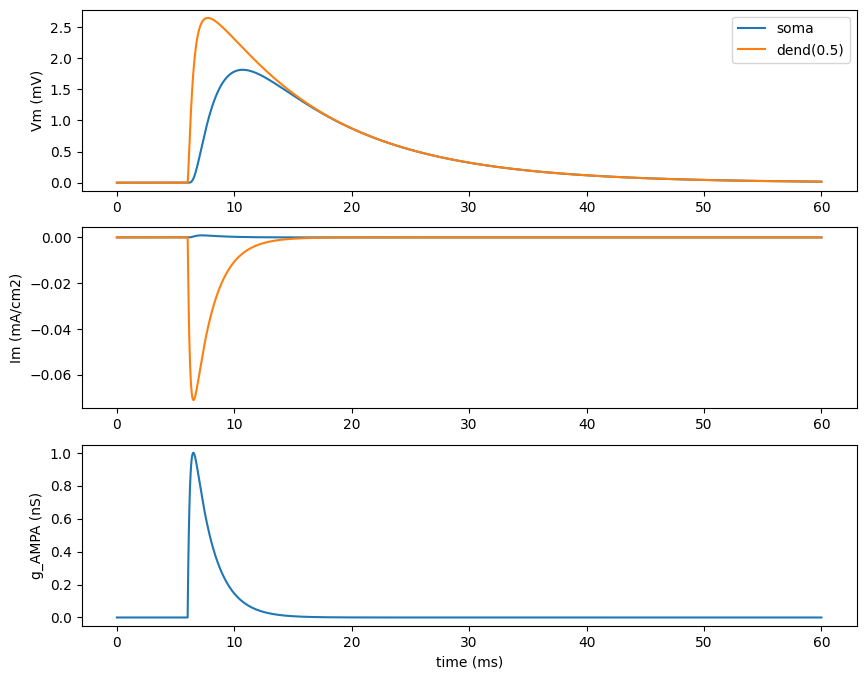

In [11]:
ampa_syn.loc(cell.dend(0.5)) # move synapse back to middle of the dendrite

# Set simulation parameters
h.dt = 0.025  # Time step (ms)
h.tstop = 60  # Duration of simulation (ms)
h.celsius = 37  # Temperature (°C)
h.v_init = cell.soma.e_pas  # Initial voltage (mV)
# Create gsyn_vec to record synaptic conductance over time
gsyn_vec = h.Vector()
gsyn_vec.record(ampa_syn._ref_g_AMPA)

# Call run_and_plot
run_and_plot(cell, gsyn_vec, 0.5)

<font color='red'>**Q2**:
How does the time course of the synaptic conductance compare to the postsynaptic potential at the location of the synapse? What properties of the cell membrane (not the synapse) govern how fast the membrane voltage can change in time in response to a synaptic input? (hint: there are multiple right answers. You can try also adjusting them above to test for yourself).
</font>

The time course of synaptic conductance change is shorter than the voltage change. The properties of the cell membrane that govern how fast membrane voltage can change include membrane capacitance (𝐶𝑚) and membrane resistance (𝑅𝑚).

A higher membrane capacitance results in slower changes in voltage in response to synaptic input, as the membrane requires more charge to change its voltage.

On the other hand, a lower membrane resistance allows more current to flow into or out of the cell, resulting in faster changes in voltage in response to synaptic input.

<font color='red'>**Q3**:
How does the time course of the excitatory postsynaptic potential (EPSP) differ between the soma and the location of the synapse?
</font>

They are almost the same but the soma might be just a little bit later/the increase isn't as sharp and peaks slightly later than the synapse location peak.

Now that we have some intuition for a baseline condition in which a single EPSP was applied, generating ~1.5 mV peak potential in the soma. Let's explore some key properties of conductance based synapses. First, we'll address the question is the voltage change generated by a synapse linear to the synaptic weight? Or, an equivalent way of asking this question is if the voltage change is linear to the number of synapses activated. This is because we can model multiple, synchronous synapses at the same compartment as the summation of each of their conductances (think of adding more conductances in our parallel conductance model).

To answer this, we'll run the same simulation we ran above in a loop while varying the synaptic weight and measuring the voltage traces at the soma. We can then extract the peak of the EPSP to assess the magnitude of postsynaptic voltage change. Since we'll do a couple experiments like this in which we sweep over a variable and extract voltage recordings and peak PSPs, I've written `plot_PSP_sweep` to plot the postsynaptic potential traces overlaid and the peak PSP vs. the variable we're changing (in this case the synaptic weight).

In [12]:
def plot_PSP_sweep(V_vecs,peakPSPs,x,x_label,y_label,x_label_str,legend_on=True):
    # Plot PSP recordings and peak PSP vs. some variable x
    # Input arguments:
    #   V_vecs - list of Vectors of voltage recordings at each value of x
    #   peakPSPs - list or array of peak postsynaptic potentials at each value of x
    #   x - list or array of values for parameter being varied in each simulation
    #   x_label - string for x-axis label of parameter being varied
    #   x_label_str - string with one {} placeholder for values to be used with .format() below, e.g. 'weight = {:.1f}'
    #   legend_on - True or False. Controls display of legend in first subplot
    fig = plt.figure()
    ax = fig.add_subplot(2,1,1)
    for v,xi in zip(V_vecs,x):
        ax.plot(t_vec,v-v[0],label=x_label_str.format(xi))
    ax.set_xlabel('time (ms)')
    ax.set_ylabel(y_label)
    if legend_on:
        ax.legend()
    ax = fig.add_subplot(2,1,2)
    ax.plot(x,peakPSPs)
    ax.set_xlabel(x_label)
    ax.set_ylabel('Peak PSP (mV)')
    fig.tight_layout()

Fill in the code block below to sweep over a range of weights from 0.1 to 100 and plot the output. You can turn off the legend if it gets crowded by setting `legend_on` to `False`.

Set weight to 0.1, x = 0.5
Set weight to 0.2, x = 0.5
Set weight to 0.4, x = 0.5
Set weight to 0.7, x = 0.5
Set weight to 1.4, x = 0.5
Set weight to 2.7, x = 0.5
Set weight to 5.2, x = 0.5
Set weight to 10.0, x = 0.5
Set weight to 19.3, x = 0.5
Set weight to 37.3, x = 0.5
Set weight to 72.0, x = 0.5
Set weight to 138.9, x = 0.5
Set weight to 268.3, x = 0.5
Set weight to 517.9, x = 0.5
Set weight to 1000.0, x = 0.5


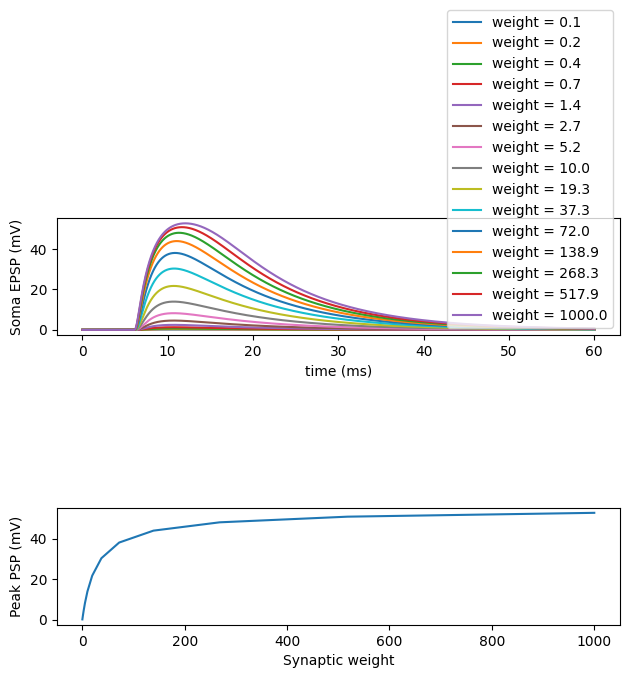

In [13]:
weight_vec = np.logspace(-1, 3, 15)

ampa_syn.loc(cell.dend(0.5))  # reposition at x = 0.5

soma_V_vecs = []  # store soma voltage recordings
soma_peakEPSPs = []  # store soma peak EPSPs

for w in weight_vec:
    nc_estim.weight[0] = w
    print('Set weight to {:.1f}, x = {:.1f}'.format(nc_estim.weight[0], ampa_syn.get_loc()))
    h.run()
    soma_V_veci = cell.soma_v.to_python(np.zeros(len(cell.soma_v)))
    soma_V_vecs.append(soma_V_veci)  # compute EPSP by subtracting baseline
    soma_peakEPSPs.append(soma_V_veci.max() - soma_V_veci[xind(t_vec, estim.start)])

soma_peakEPSPs = np.array(soma_peakEPSPs)

nc_estim.weight[0] = 1  # reset weight to 1

plot_PSP_sweep(soma_V_vecs, soma_peakEPSPs, weight_vec, 'Synaptic weight', 'Soma EPSP (mV)', 'weight = {:.1f}')

<font color='red'>**Q4**:
Is the peak PSP linear with respect to synaptic weight? What happens to the peak EPSP at higher synaptic weights?
</font>

No- it appears to be a logarithmic relationship. Peak EPSP starts to increase by less at higher synaptic weights and might even approach steady state at some point, though it is difficult to see at only 100 synaptic weight (which is why I increased to 1000).

<font color='red'>**Q5**:
Can you extrapolate from this to predict how two synchronous EPSPs would sum when at the same location vs. at different locations, i.e. how would the total EPSP compare to the sum of the two individual EPSPs if they had occurred in isolation.
</font>

If two EPSPs occur synchronously at the same location, their individual EPSPs will sum linearly, resulting in a total EPSP that is approximately twice the amplitude of a single EPSP.

However, if the EPSPs occur at different locations, their sum will be less than twice the amplitude of a single EPSP due to dendritic filtering and attenuation. The total EPSP will depend on the relative distances of the synapses from the soma, their respective synaptic weights, and the passive cable properties of the dendrite.

## Effect of synapse location

Next, we'll look at how the location of the synapse affects the shape and magnitude of the EPSP.

Below, try moving the synapse to 5 locations between `x = 0.1` and `0.9` in the dendrite (`cell.dend`) in a `for` loop and saving both the somatic voltage recordings/peak EPSPs and dendritic recordings/peak EPSP (at the site of the synapse). You can copy the code structure we used above, changing variable name as needed.

Then, use `plot_PSP_sweep` to plot the voltage traces and peak EPSP vs. position for the soma and dendrite.

Now try moving the synapse. How does the shape and amplitude of the EPSP at the soma change as a function of distance?

Moved synapse to x = 0.1, dist = 107.8 um
Moved synapse to x = 0.3, dist = 303.9 um
Moved synapse to x = 0.5, dist = 500.0 um
Moved synapse to x = 0.7, dist = 696.1 um
Moved synapse to x = 0.9, dist = 892.2 um


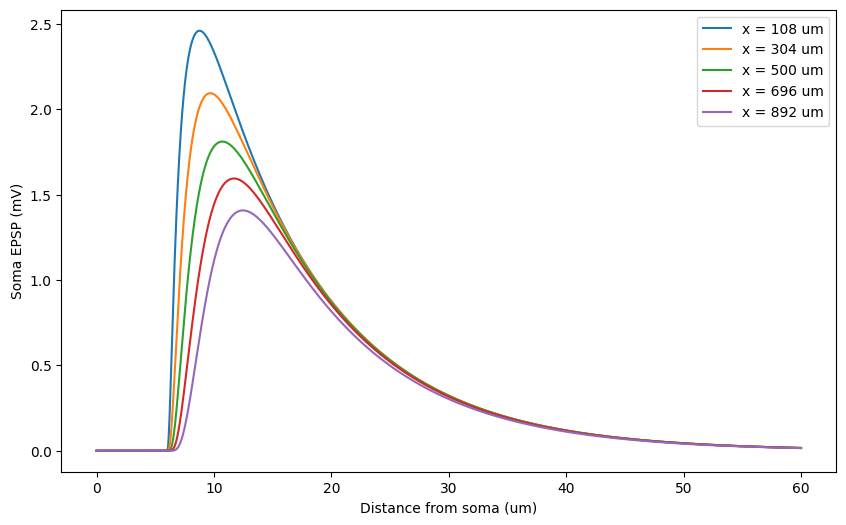

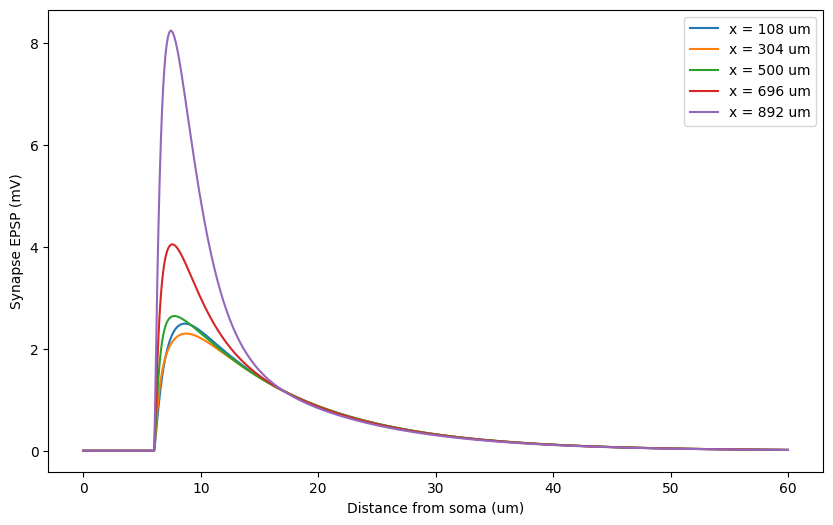

In [14]:
# Your code goes here
syn_locs =  np.linspace(0.1, 0.9, 5)# normalized distance within dendrite

# Initialize lists to starte vectors and EPSPs
syn_dists = [] # store distance in um
soma_V_vecs = [] #store soma voltage recordings
soma_peakEPSPs = [] # store soma peak EPSPs
synloc_V_vecs = [] # store EPSP at location of synapse
synloc_peakEPSPs = []
for x in syn_locs:
    # Move synapse to cell.dend(x)
    ampa_syn.loc(cell.dend(x))

    # your code goes here

    distx = ampa_syn.get_loc()*cell.dend.L
    syn_dists.append(distx)
    print('Moved synapse to x = {:.1f}, dist = {:.1f} um'.format(ampa_syn.get_loc(),distx))
    h.run()
    # Your code goes here
    # Store recording vectors
    soma_V_vec = list(cell.soma_v)
    soma_V_vecs.append(soma_V_vec)
    soma_peakEPSPs.append(max(soma_V_vec) - soma_V_vec[xind(t_vec, estim.start)])

    synloc_V_vec = h.Vector().record(cell.dend(x)._ref_v)
    h.run()  # Make sure the recording is complete
    synloc_V_vecs.append(list(synloc_V_vec))  # Convert to Python list for compatibility with plot function
    synloc_peakEPSPs.append(max(synloc_V_vec) - synloc_V_vec[xind(t_vec, estim.start)])


    # Return synapse to middle of dendrite for next iteration
    ampa_syn.loc(cell.dend(0.5))

#ampa_syn.loc(cell.dend(0.5)) # return synapse to middle of dendrite
soma_peakEPSPs = np.array(soma_peakEPSPs)
synloc_peakEPSPs = np.array(synloc_peakEPSPs)

x_label = 'Distance from soma (um)'
x_label_str = 'x = {:.0f} um'

# Plot
def plot_PSP_sweep(V_vecs, peakPSPs, x, x_label, y_label, x_label_str, legend_on=False):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    for v, xi in zip(V_vecs, x):
        ax.plot(t_vec, v - np.array(v)[0], label=x_label_str.format(xi))
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if legend_on:
        ax.legend()
    plt.show()

plot_PSP_sweep(soma_V_vecs, soma_peakEPSPs, syn_dists, 'Distance from soma (um)', 'Soma EPSP (mV)', 'x = {:.0f} um', legend_on=True)
plot_PSP_sweep(synloc_V_vecs, synloc_peakEPSPs, syn_dists, 'Distance from soma (um)', 'Synapse EPSP (mV)', 'x = {:.0f} um', legend_on=True)

<font color='red'>**Q6**:
How does the somatic EPSP amplitude and shape change as the synapse is moved to more distant locations?
</font>

The somatic EPSP amplitude decreases as the synapse is moved further away.

<font color='red'>**Q7**:
How does the local dendritic EPSP amplitude change as the synapse is moved to more distant locations? Explain why this occurs in terms of the input resistance.
</font>

Because the dendrites are smaller in diameter further from the soma, the input resistance is less meaning that the EPSPs generated further from the soma will be bigger (but by the time these potentials reach the soma the attenuation/membrane resistance/capacitance will render the EPSP much smaller than what is measured at the synapse).

One useful measure is the ratio of the peak EPSP at the dendritic location vs. at the soma (where the voltage needs to reach threshold to initiate an action potential), also known as the voltage *attenuation*. Using the variables you generated above, plot the ratio of soma peak EPSP to dendritic peak EPSP vs. distance from soma.

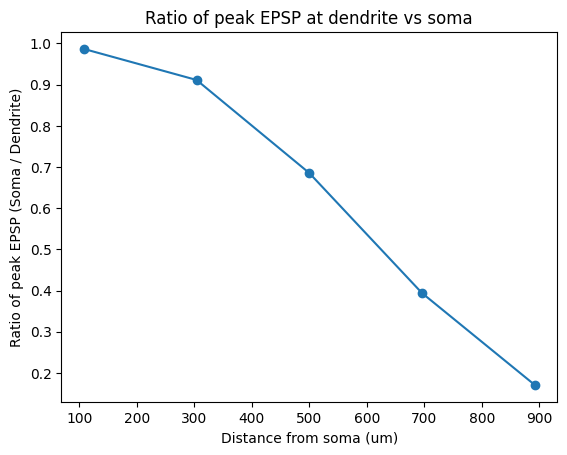

In [15]:
# Plot ratio of peak EPSP at dendrite vs soma
# Your code goes here
plt.figure()
plt.plot(syn_dists, soma_peakEPSPs / synloc_peakEPSPs, marker='o')
plt.xlabel('Distance from soma (um)')
plt.ylabel('Ratio of peak EPSP (Soma / Dendrite)')
plt.title('Ratio of peak EPSP at dendrite vs soma')
plt.show()


<font color='red'>**Q8**:
What cable parameters would reduce the EPSP attenuation (i.e., increase the somatic EPSP for distal inputs)? (there are multiple possible answers)
</font>

To reduce EPSP attenuation, we could increase dendritic diameter (lower input resistance), decrease dendritic length (less voltage attenuation), increase membrane resistance (less leaky current), increase axial resistance (less voltage attenuation), and/or increase membrane capacitance (decrease time constant).

# Shunting inhibition

Inhibitory synapses suppress the excitability of target cells, but the nature of this suppression depends on when and where they occur, as well as what aspect of the postsynaptic neuron's activity we look at. One important mechanism is called *shunting inhibition* which can have a divisive or subtractive effect on the postsynaptic neuron. We'll explore this phenomonon below.

First, let's make a GABA<sub>A</sub>  inhibitory synapse, which is the major inhibitory neurotransmitter in the brain. We'll use a similar synaptic mechanism as the `ProbAMPANMDA.mod` mechanism we used above, this time called `ProbGABAA`. It works exactly the same way, except it only contains the GABA<sub>A</sub> current. Note: we could have used the same membrane mechanism as above and altered the rise and decay time constants and the reversal potentials to achieve the same synaptic conductance, since the underlying equations are the same.

Fill in the code below to create an inhibitory synapse at `x = 0.5`. Set the rise and decay time constants to $0.2 \; ms$ and $8 \;  ms$, and reversal potential to $-70 \; mV$. We'll also move our excitatory synapse back to that location.

As we did above, create a `NetStim` object called `istim`, a `NetCon` object called `nc_istim` with `delay = 1` and `weight = 1`. The last two lines create recording vectors for the GABA<sub>A</sub> synaptic conductance and current.

In [16]:
syn_x_loc = 0.5
gabaa_syn = h.ProbGABAA(cell.dend(syn_x_loc))
gabaa_syn.tau_r = 0.2  # rise time constant (ms)
gabaa_syn.tau_d = 8.0  # decay time constant (ms)
gabaa_syn.e = -70  # reversal potential (mV)

ampa_syn.loc(syn_x_loc)  # move excitatory synapse back to this location

# Create NetStim object to generate artificial presynaptic events
istim = h.NetStim()

# Create NetCon object to connect the netstim presynaptic events to the postsynaptic conductance
nc_istim = h.NetCon(istim, gabaa_syn)
nc_istim.delay = 1  # (ms)
nc_istim.weight[0] = 1  # weight (arbitrary)

# Recording vectors
ggabaa_vec = h.Vector().record(gabaa_syn._ref_g)  # record gabaa conductance
igabaa_vec = h.Vector().record(gabaa_syn._ref_i)  # record gabaa conductance

Let's first look at the effect of the inhibitory synapse in isolation.
Below, turn off the excitatory synapse by setting its associated `NetStim`'s weight to 0, use the inhibitory synapse's `NetStim` to evoke an IPSP at $5 \; ms$. Then, use `run_and_plot` to plot the inhibitory postsynaptic potential (IPSP), current, and conductance.

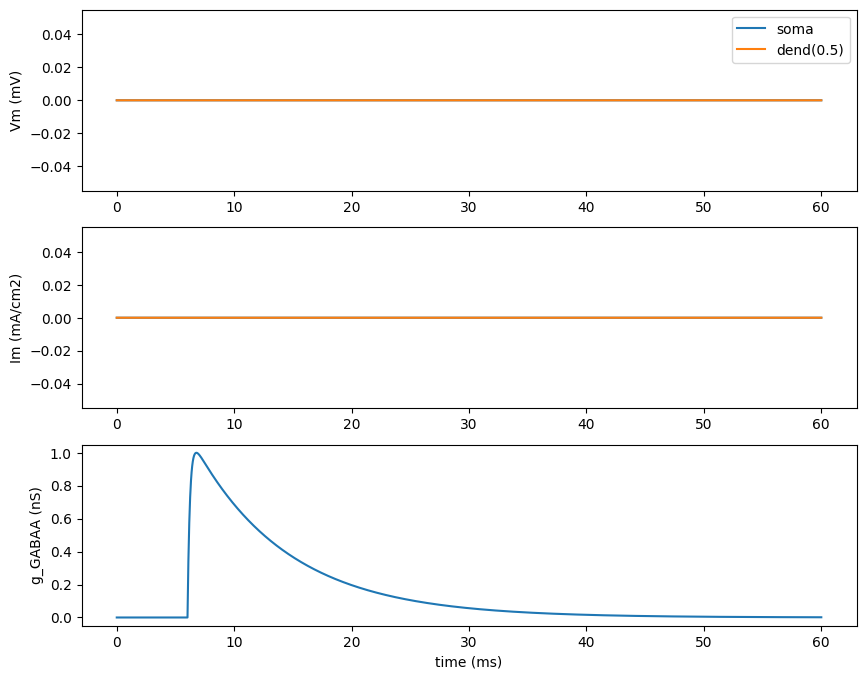

In [17]:
# Specify NetStim parameters
istim.number = 1  # number of spikes
istim.start = 5  # time of 1st spike (ms)
istim.noise = 0  # randomness, set to 0 for deterministic, 1 for random (Poisson process)

# turn off excitatory synapse here
nc_estim.weight[0] = 0

# Fill in arguments for run_and_plot
run_and_plot(cell, ggabaa_vec, syn_x_loc, syn_label='g_GABAA')

nc_estim.weight[0] = 1  # reset excitatory synapse weight here


<font color='red'>**Q9**:
Why is there a conductance change but no membrane current or IPSP? (Hint: $I_{syn} = g_{syn}(V - E_{syn})$)
</font>


The conductance change occurs because the inhibitory GABA synapse opens, allowing ions to flow across the membrane, leading to a change in conductance. However, the reversal potential of the inhibitory synapse is close to the resting membrane potential which is why there is a negligible membrane current and IPSP.

It appears that our inhibitory synapse is *silent*, in that it has no effect on the postynaptic voltage. Hopefully, you discussed in your answer above why this occurs in our specific scenario, which should imply this isn't always the case. But let's continue to explore the impact of this so-called silent synapse on excitatory inputs that arrive at the same time.

Below, we'll use a similar loop to the two we did in the previous section to test the effect of inhibitory weight on the EPSP generated by an excitatory input.

With the weight of the excitatory synapse fixed to 1, vary the weight of the inhibitory synapse from 0 to 100 and record the somatic voltage and peak EPSPs (as we did above). Both synapses should be placed at the middle of the dendrite (`x = 0.5`). Then, use `plot_PSP_sweep` to visualize the somatic voltage traces and peak EPSP vs. inhibitory weight.

Set GABAA weight to 0.0, x = 0.5
Set GABAA weight to 7.1, x = 0.5
Set GABAA weight to 14.3, x = 0.5
Set GABAA weight to 21.4, x = 0.5
Set GABAA weight to 28.6, x = 0.5
Set GABAA weight to 35.7, x = 0.5
Set GABAA weight to 42.9, x = 0.5
Set GABAA weight to 50.0, x = 0.5
Set GABAA weight to 57.1, x = 0.5
Set GABAA weight to 64.3, x = 0.5
Set GABAA weight to 71.4, x = 0.5
Set GABAA weight to 78.6, x = 0.5
Set GABAA weight to 85.7, x = 0.5
Set GABAA weight to 92.9, x = 0.5
Set GABAA weight to 100.0, x = 0.5


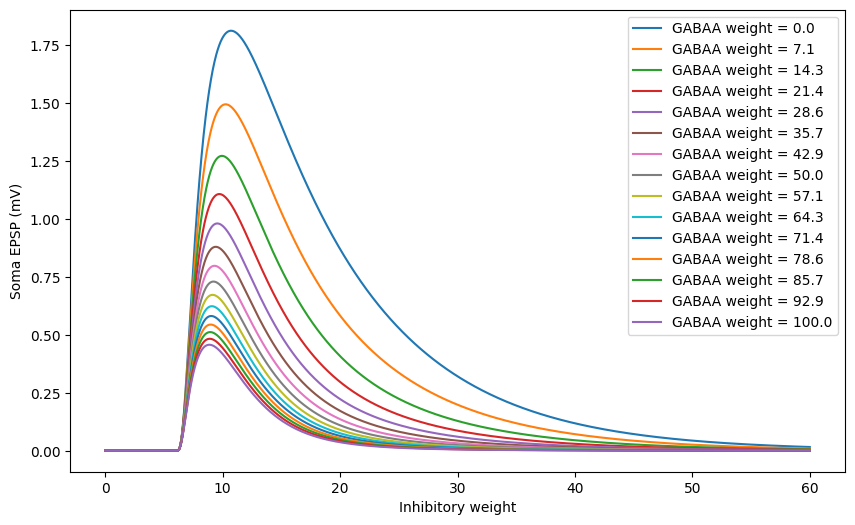

In [18]:
nc_estim.weight[0] = 1
weight_vec = np.linspace(0, 100, 15)  # generate vector of inhibitory weights

soma_V_vecs = []  # store soma voltage recordings
soma_peakEPSPs = []  # store soma peak EPSPs
ampa_syn.loc(cell.dend(syn_x_loc))
gabaa_syn.loc(cell.dend(syn_x_loc))

for w in weight_vec:
    # change inhibitory weight
    nc_istim.weight[0] = w
    print('Set GABAA weight to {:.1f}, x = {:.1f}'.format(nc_istim.weight[0], gabaa_syn.get_loc()))
    h.run()
    soma_V_veci = cell.soma_v.to_python(np.zeros(len(cell.soma_v)))
    soma_V_vecs.append(soma_V_veci - soma_V_veci[xind(t_vec, estim.start)])  # subtract baseline
    soma_peakEPSPs.append(soma_V_veci.max() - soma_V_veci[xind(t_vec, estim.start)])

soma_peakEPSPs = np.array(soma_peakEPSPs)

nc_istim.weight[0] = 1  # reset back to 1
istim.start = 5  # reset back to 5 ms
estim.start = 5  # reset back to 5 ms

# fill in arguments of plot_PSP_sweep
plot_PSP_sweep(soma_V_vecs, soma_peakEPSPs, weight_vec, 'Inhibitory weight', 'Soma EPSP (mV)', 'GABAA weight = {:.1f}', legend_on=True)

You should see the PSP decrease in size with increasing GABA weight. You've just demonstrated the principle of shunting inhibition! Despite having no independent effect on the postsynaptic potential, the inhibitory synapse is able to suppress the effect of an excitatory input. Interestingly, the strength of inhibition is not linear with respect to the strength of the inhibitory synapse, with  a $1/g_{GABAA}$ relationship. In this way, the combination of the inhibitory and excitatory synapse implements a form of *division* as the postsynaptic voltage is roughly proportional to the ratio of the excitatory and inhibitory conductance ($V \propto g_{AMPA}/g_{GABAA}$), particularly as the inhibitory conductance becomes much larger than the excitatory conductance.

<font color='red'>**Q10**:
How would the spatial or temporal alignment of the excitatory and inhibitory inputs affect the degree of division by the inhibitory synapse? To help you answer this question, try modifying the timing (`istim.start`) or location (`gabaa_syn.loc(cell.dend(x))`) of the synapses in the code block above and regenerating your plots.
</font>

<font color='red'>
Bonus: Compare the situation in which the inhibitory conductance is more proximal (closer to the soma) than the excitatory synapse to the situation in which its more distal (further from the soma) than the excitatory synapse. In which situation does the inhibitory synapse have more influence on the EPSP?
</font>

Spatial Alignment:
When the inhibitory synapse is closer to the soma than the excitatory synapse, it has more influence on the EPSP. This is because the inhibitory conductance acts to shunt the EPSP before it can propagate to the soma, effectively reducing its amplitude.
Conversely, when the inhibitory synapse is more distal than the excitatory synapse, its influence on the EPSP decreases.

Temporal Alignment:
If the inhibitory synapse fires slightly before the excitatory synapse, it has a stronger effect on the EPSP. This is because the inhibitory conductance starts to shunt the EPSP before it reaches its peak.
Conversely, if the inhibitory synapse fires slightly after the excitatory synapse, its effect on the EPSP is reduced.

So we've demonstrated how shunting inhibition can have a divisive effect on postsynaptic voltage, but what about the firing rate? A widely held, but still hotly debated, view is that neuron's encode and transmit information in their firing rates. So it would seem crucial to also understand how inhibitory synapses affect the neuron's firing rate.

To address this, we'll create another `BallAndStick` model, but this time incorporating the leaky-integrate-and-fire mechanism (borrowed from Exercise 5). We'd like to know how the input-output properties of the neuron are altered in the presence of shunting inhibition. As we did before, we'll characterize this using the *frequency-input* curve by measuring the firing rate (in Hz) as a function of constant current input. We could use excitatory synaptic inputs instead but this would make things unnecessarily complicated for now.

Below, create a new cell called `lif_cell` with the `BallAndStick` class. Make sure to give it `'LIF'` for the second argument (the first argument, `gid`, doesn't matter so you can set it to whatever you want).

Then, add a current clamp called `iclamp2` to the soma and a GABAergic synapse called `gabaa_syn2` with identical properties as above (hint: the defaults are already what we want). For the current clamp, use a delay of $5 \; ms$ and duration of $100 \; ms$ (the amplitude will be set later).

In [19]:
# Create a new cell with the BallAndStick class
lif_cell = BallAndStick(0, 'LIF')

# Current clamp settings
iclamp2 = h.IClamp(lif_cell.soma(0.5))
iclamp2.delay = 5
iclamp2.dur = 100

# Inhibitory synapse
gabaa_syn2 = h.ProbGABAA(lif_cell.dend(0.5))

Now, we need to generate presynaptic inputs to drive the inhibitory synapse and connect it to the postsynaptic conductance.

Create a `NetStim` called `istim2` to generate the presynaptic inputs. We'll make use of the other parameters of the `NetStim` to generate a train of inhibitory synaptic inputs at $100 \; Hz$ (100 per second) by setting the `interval` to $10 \; ms$ and `number` to some arbitrarily big number (`1e6` sounds good). Start the synaptic inputs at $0 \; ms$. This may seem high, but keep in mind, neurons receive thousands of synaptic inputs, all of which may be individually firing at ~1-20 Hz on average. Together, that would generate many thousands of synaptic events per second distributed throughout the dendritic tree.

Lastly, create a `NetCon` called `nc_istim2` that connects `istim2` (pre) to `gabaa_syn2` (post) with `delay = 1` and `weight[0] = 1`.

In [20]:
# Create NetStim object to generate artificial presynaptic events
istim2 = h.NetStim()

# Specify NetStim parameters
istim2.number = 1e6  # number of spikes
istim2.interval = 10  # 100 Hz
istim2.start = 0  # time of 1st spike (ms)
istim2.noise = 0  # randomness, set to 0 for deterministic, 1 for random (Poisson process)

# Create NetCon object to connect the netstim presynaptic events to the postsynaptic conductance
nc_istim2 = h.NetCon(istim2, gabaa_syn2)
nc_istim2.delay = 1
nc_istim2.weight[0] = 1

Let's first run a simulation to see the firing behavior of our neuron in the absence of inhibition. Use the code block below to apply a $0.5 \; nA$ pulse.

Run the simulation for $100 \; ms$ with an initial voltage of $-70 \; mV$.

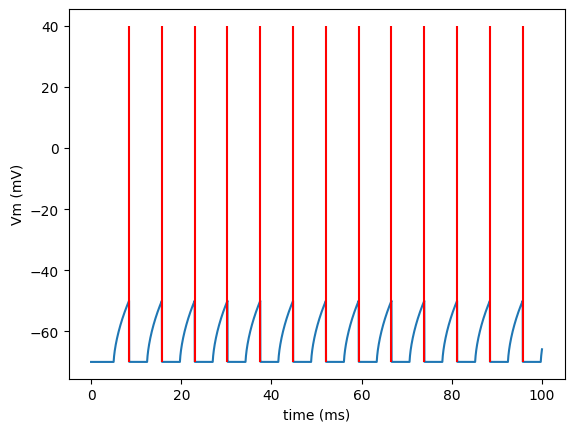

In [21]:
# Current injection parameters
iclamp2.amp = 0.5  # nA

# Inhibitory synapse parameters
nc_istim2.weight[0] = 0

h.tstop = 100  # ms
h.v_init = -70  # mV
h.run()

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t_vec, lif_cell.soma_v)
ax.vlines(np.array(lif_cell.spike_times), ymin=lif_cell.soma(0.5).e_pas, ymax=40, colors='r')
ax.set_xlabel('time (ms)')
ax.set_ylabel('Vm (mV)')
plt.show()

You should see about $13$ APs over the $100 \; ms$ simulation, indicating a firing rate $\approx 130 \; Hz$.

Now, use the `simFIcurve` function below to generate a family of F–I curves as you vary the weight of the inhibitory synapse and plot the F-I curves on the same axes. For the F–I curves, vary the current amplitude between $0$ and $1.5 \; nA$ for inhibitory weights of 0 to 50 in steps of 10. This may take some time (<30 sec), depending on how many steps you use in your F-I curve.

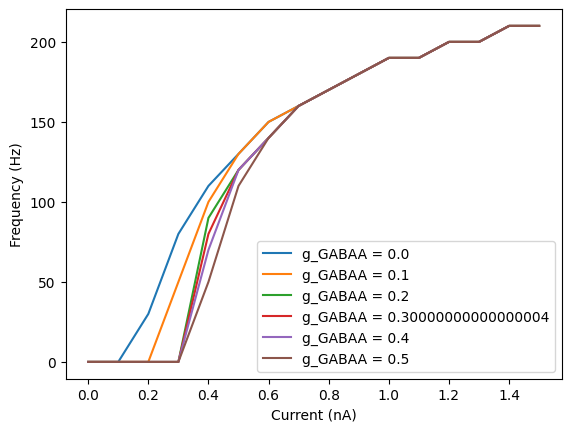

In [22]:
def simFIcurve(cell, iclamp, curr_amps):
    # Runs simulation and saves firing frequency
    # Note: frequency calculated using duration of current clamp, if tstop < iclamp.dur this will underestimate firing rate
    # Input arguments
    #   cell - cell model object
    #   iclamp - IClamp object
    #   curr_amps - list/array of current amplitudes to set iclamp.amp
    F_vec = []
    for amp in curr_amps:
        iclamp.amp = amp
        h.run()
        F_vec.append(len(cell.spike_times) / (iclamp.dur * 1e-3))  # Frequency in Hz

    return F_vec

# Your code goes here
curr_amps = np.linspace(0, 1.5, 16)  # Current amplitudes in nA
weight_vec = np.arange(0, 51, 10)  # Inhibitory weights from 0 to 50 in steps of 10

# Loop over weights and generate frequency vectors
F_vecs = []
for w in weight_vec:
    # set nc_istim2.weight[0]
    nc_istim2.weight[0] = w

    # run simFIcurve and output F_vec
    F_vec = simFIcurve(lif_cell, iclamp2, curr_amps)

    # append F_vec to F_vecs list
    F_vecs.append(F_vec)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
# use for loop and zip to plot each F_vec in F_vecs and label with corresponding current amplitude (in curr_amps)
for F, curr_amp in zip(F_vecs, curr_amps):
    ax.plot(curr_amps, F, label='g_GABAA = {}'.format(curr_amp))
ax.set_xlabel('Current (nA)')
ax.set_ylabel('Frequency (Hz)')
ax.legend()
plt.show()

<font color='red'>**Q11**:
Did increasing the inhibitory weight (conductance) have a divisive or subtractive effect on the F-I curves? Hint: to answer this, how would you modify/shift one curve to make it resemble the others?
</font>


Increasing the inhibitory weight (conductance) had a divisive effect on the F-I curves. The curves are not shifted left/right or up/down they just have different initial behavior/ where the slope and start time of increase are different.